In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, vstack
import glob

In [2]:
rcParams.update({'font.size': 14})

In [3]:
t = Table.read('../data/10700_activity.csv')

In [4]:
t.columns

<TableColumns names=('File','Time [MJD]','Epoch','SNR','CBC RV [m/s]','CBC RV Err. [m/s]','CCF RV [m/s]','CCF RV Err. [m/s]','S Value','H-alpha Emission','H-alpha Equiv. Width [A]','CCF FWHM [m/s]','CCF FWHM Err. [m/s]','BIS [m/s]','V_span [m/s]','Bi-Gaussian [m/s]','Skew Normal','Date Generated','Phot. GP [mag]','Phot. GP Err. [mag]')>

In [5]:
#start_ind, end_ind = 26,46
start_ind, end_ind = 0,100
time = np.copy(t['Time [MJD]'][start_ind:end_ind])
rv = np.copy(t['CBC RV [m/s]'][start_ind:end_ind])
time -= np.median(time)

In [6]:
halpha_emission = t['H-alpha Emission'][start_ind:end_ind]
halpha_ew = t['H-alpha Equiv. Width [A]'][start_ind:end_ind]

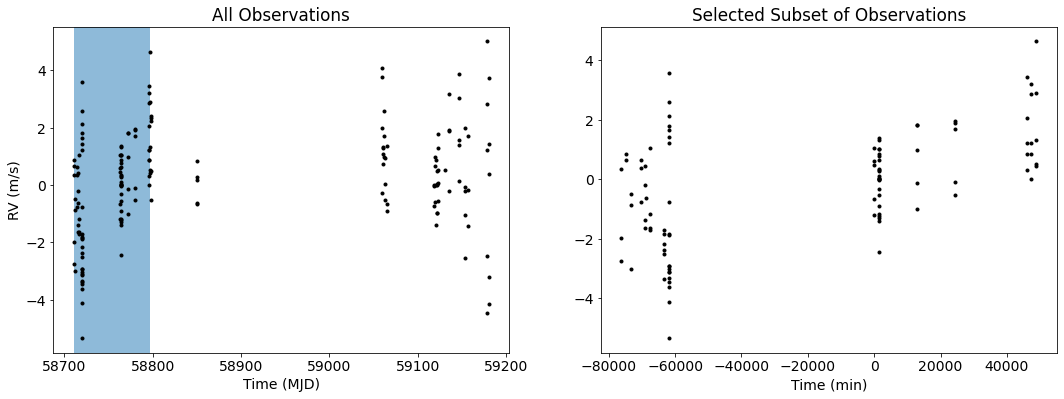

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.plot(t['Time [MJD]'], t['CBC RV [m/s]'], 'k.')
ax1.axvspan(t['Time [MJD]'][start_ind], t['Time [MJD]'][end_ind-1], alpha=0.5)
ax1.set_ylabel('RV (m/s)')
ax1.set_xlabel('Time (MJD)')
ax2.plot(time*24.*60., rv, 'k.')
ax2.set_xlabel('Time (min)')
ax1.set_title('All Observations')
ax2.set_title('Selected Subset of Observations');

In [8]:
#hdus[1].header

In [9]:
n_frames = len(time)
airmass = np.zeros(n_frames)
pwv = np.zeros_like(airmass)  # precipitable water vapor
moondist = np.zeros_like(airmass)
exptime = np.zeros_like(airmass)
for i,f in enumerate(t['File'][start_ind:end_ind]):
    with fits.open('../data/10700_spectra/{}'.format(f)) as hdus:
        #print(len(hdus[2].data['midpoints']))
        airmass[i] = hdus[0].header['AIRMASS']
        pwv[i] = hdus[1].header['PWV']
        moondist[i] = hdus[0].header['MOONDIST']
        exptime[i] = hdus[0].header['AEXPTIME']
        
max_reads = int(np.ceil(np.max(exptime)))  # max subframes
micro_time = np.zeros((len(time), max_reads)) # frame # x subframe #
micro_wave = np.zeros((len(time), max_reads, 512)) # frame # x subframe # x wavelength
micro_flux = np.zeros_like(micro_wave) + np.nan
for i,f in enumerate(t['File'][start_ind:end_ind]):
    with fits.open('../data/10700_spectra/{}'.format(f)) as hdus:
        n_reads = len(hdus[2].data['midpoints'])  # number of subframes
        micro_time[i,:n_reads] = hdus[2].data['midpoints']
        micro_wave[i,:n_reads,:] = hdus[2].data['wavelengths']
        micro_flux[i,:n_reads,:] = hdus[2].data['expm_specs']
        for j in range(n_reads): # check that the wavelength grid is consistent across all expm spectra for this observation
            assert np.all(micro_wave[i,0,:] - micro_wave[i,j,:] == 0)

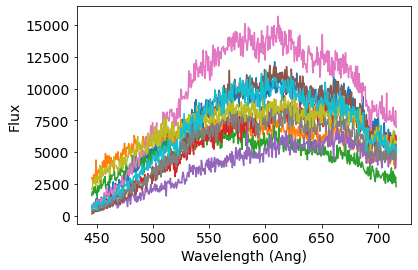

In [11]:
for i in np.arange(0,n_frames,int(n_frames/10)):
    plt.plot(micro_wave[i,0,:],micro_flux[i,0,:])
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux');

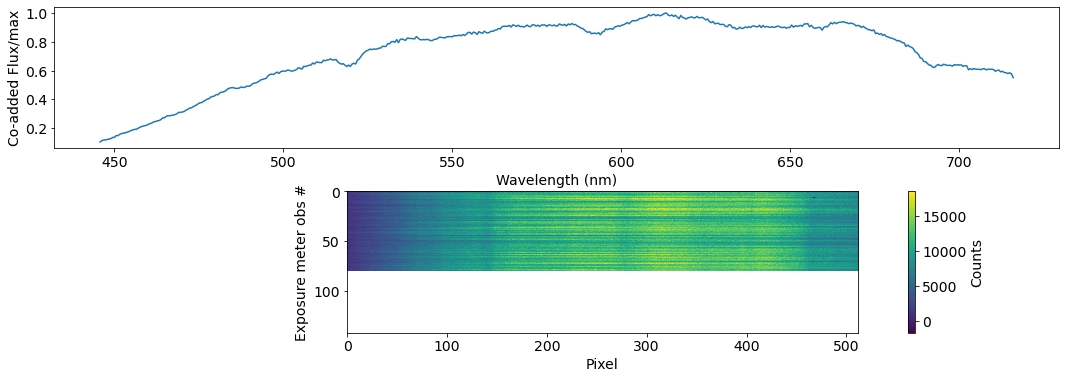

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,6), gridspec_kw={'hspace':0.3})
ax1.plot(micro_wave[0,0,:], np.nansum(micro_flux, axis=1)[0]/np.nanmax(np.nansum(micro_flux, axis=1)[0]))
im = ax2.imshow(micro_flux[0,:,:])
plt.colorbar(im, ax=ax2, label='Counts')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Co-added Flux/max')
ax2.set_ylabel('Exposure meter obs #')
ax2.set_xlabel('Pixel');

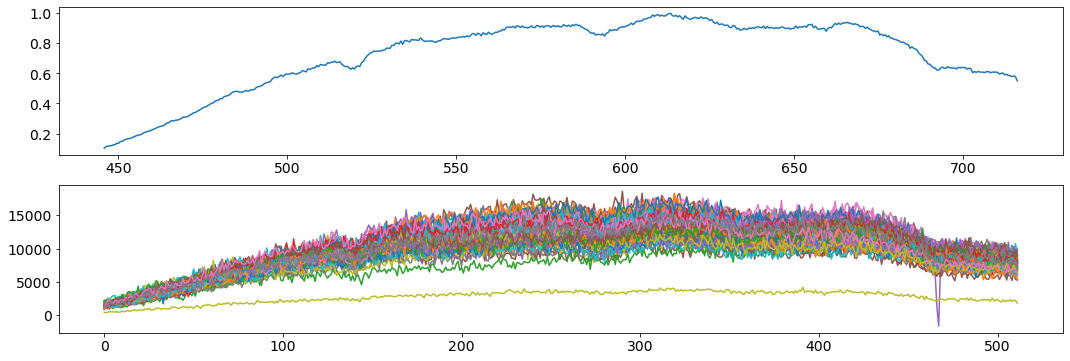

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,6))
ax1.plot(micro_wave[0,0,:], np.nansum(micro_flux, axis=1)[0]/np.nanmax(np.nansum(micro_flux, axis=1)[0]))
ax2.plot(micro_flux[0,2:-2,:].T);

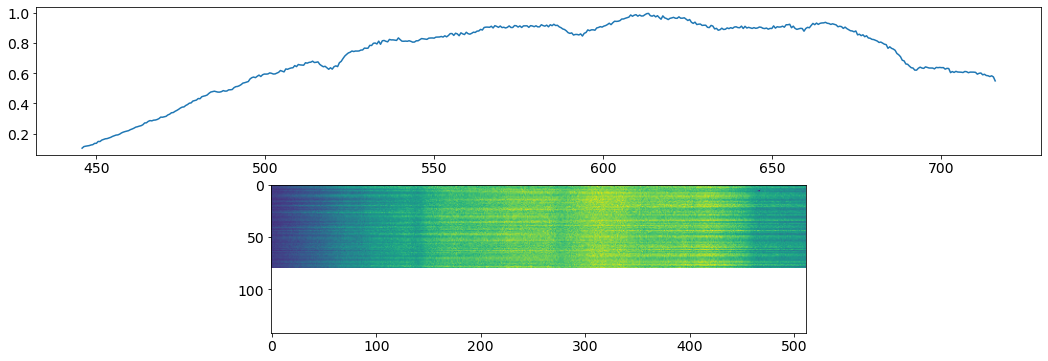

In [14]:
obs = 0
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,6))
ax1.plot(micro_wave[obs,0,:], np.nansum(micro_flux, axis=1)[obs]/np.nanmax(np.nansum(micro_flux, axis=1)[obs]))
micro_flux_norm = micro_flux[obs,:,:]/np.median(micro_flux[obs,:,:], axis=1)[:, None]
ax2.imshow(micro_flux_norm);

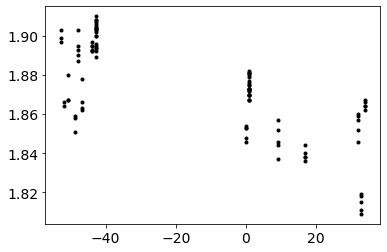

In [15]:
plt.plot(time, halpha_ew, 'k.');

#### remove major trends from the exposure meter data:

In [16]:
avg = np.nanmedian(micro_flux, axis=(0, 1))
avg /= avg.mean()

diag = np.diag(np.ones(micro_flux.shape[1]))

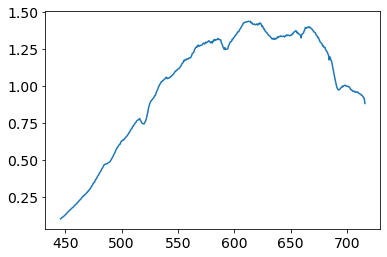

In [17]:
plt.plot(micro_wave[0,0,:], avg)

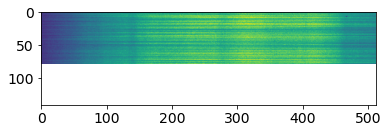

In [18]:
plt.imshow(micro_flux[0])

In [71]:
X0 = np.asarray([(diag[idx][:, None] *  avg).ravel() for idx in range(micro_flux.shape[1])]).T
#X1 = np.asarray([(diag[idx][:, None] *  avg**2).ravel() for idx in range(micro_flux.shape[1])]).T
X2 = np.asarray([(diag[idx][:, None] *  np.ones(micro_flux.shape[2])).ravel() for idx in range(micro_flux.shape[1])]).T
X3 = np.asarray([(diag[idx][:, None] *  np.arange(micro_flux.shape[2])).ravel() for idx in range(micro_flux.shape[1])]).T
#X = np.hstack([X0, X0**2, X0**3, X2, X3])
X = np.hstack([X0, X2, X3, X3**2, X3**3])



micro_resid = np.zeros_like(micro_flux)
micro_sig = np.zeros_like(micro_flux)
micro_weights = np.zeros((n_frames, X.shape[1]))

for jdx in range(n_frames):
    y = micro_flux[jdx].ravel()
    yerr = micro_flux[jdx].ravel()**0.5
    prior_mu = np.hstack([np.nanmean(micro_flux[jdx], axis=1), np.zeros(X.shape[1] - X0.shape[1])])
    prior_sigma = np.hstack([np.abs(np.nanmean(micro_flux[jdx], axis=1)) * 0.25,
                             #np.nanmean(micro_flux[jdx], axis=1) * 0.05,
                             np.ones(X0.shape[1]) * 10,
                             np.ones(X.shape[1] - X0.shape[1]*2) * 1000000])
    prior_mu = np.nan_to_num(prior_mu)
    prior_sigma = np.nan_to_num(prior_sigma, nan=1e7)

    mask = (y > 0.) & np.isfinite(y)
    sigma_w_inv = X[mask].T.dot(X[mask]/yerr[mask, None]**2)
    B = X[mask].T.dot(y[mask]/yerr[mask]**2)
    w  = np.linalg.solve(sigma_w_inv + np.diag(1/prior_sigma**2), B + prior_mu/prior_sigma**2)
    model = X.dot(w)
    micro_resid[jdx,:,:] = (y - model).reshape(micro_flux.shape[1:])
    micro_sig[jdx,:,:] = ((y - model)/yerr).reshape(micro_flux.shape[1:])
    micro_weights[jdx,:] = w


<ipython-input-71-59321450df0d>:16: RuntimeWarning: invalid value encountered in sqrt
  yerr = micro_flux[jdx].ravel()**0.5
<ipython-input-71-59321450df0d>:17: RuntimeWarning: Mean of empty slice
  prior_mu = np.hstack([np.nanmean(micro_flux[jdx], axis=1), np.zeros(X.shape[1] - X0.shape[1])])
<ipython-input-71-59321450df0d>:18: RuntimeWarning: Mean of empty slice
  prior_sigma = np.hstack([np.abs(np.nanmean(micro_flux[jdx], axis=1)) * 0.25,
<ipython-input-71-59321450df0d>:31: RuntimeWarning: divide by zero encountered in true_divide
  micro_sig[jdx,:,:] = ((y - model)/yerr).reshape(micro_flux.shape[1:])


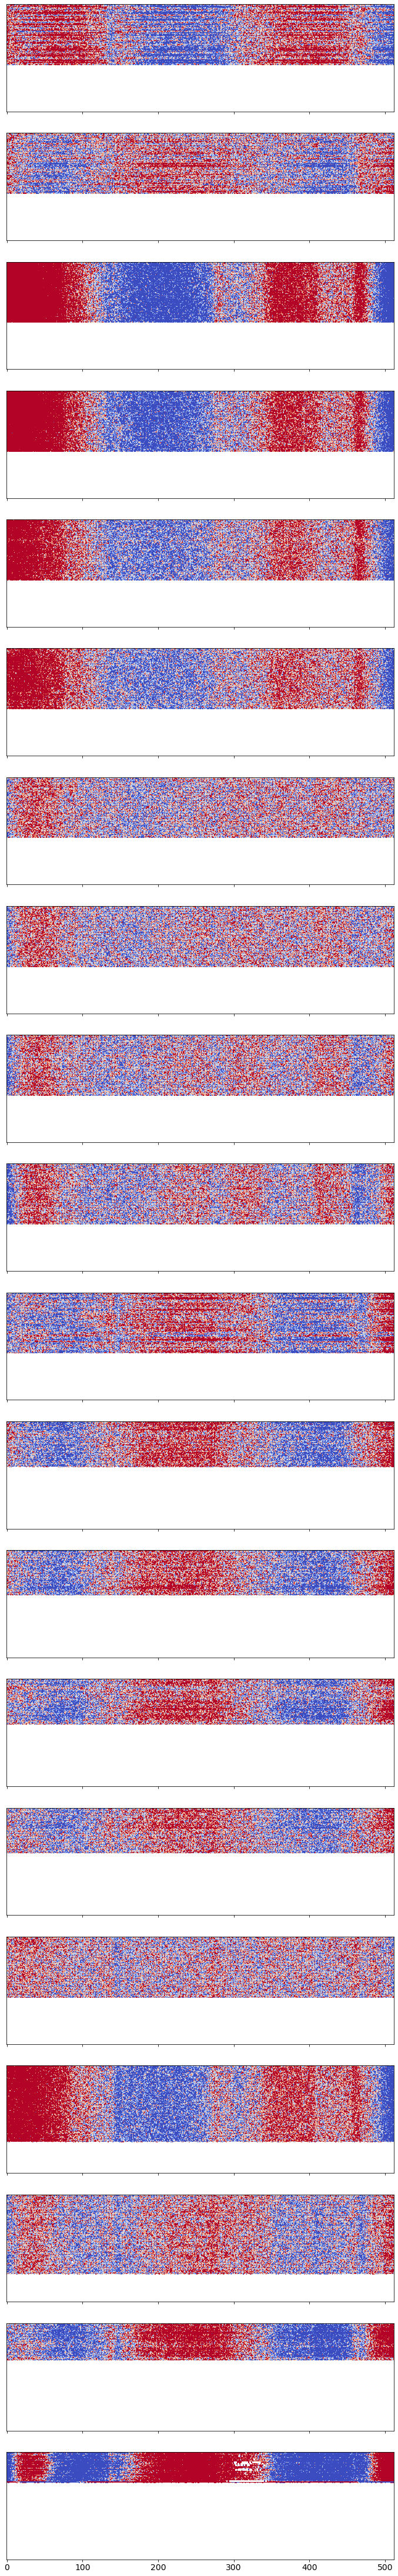

In [88]:
#fig, axes = plt.subplots(n_frames,1, figsize=(100,100))
fig, axes = plt.subplots(20,1, figsize=(20,80))
increment = int(n_frames/20)

for i,ax in enumerate(axes):
#    plt.imshow(((y - model)).reshape(micro_flux.shape[1:]), cmap='coolwarm', vmin=0.5, vmax=1.5)
    ax.imshow(micro_sig[i*increment], cmap='coolwarm', vmin=-5, vmax=5)
    if not i == (len(axes) - 1):
        ax.set_xticklabels([])
    ax.set_yticks([])
    #break

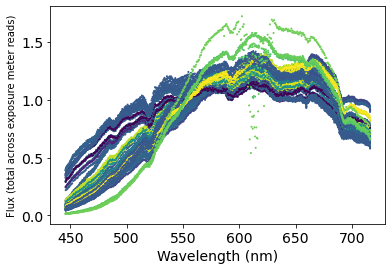

In [22]:
plt.figure()
meta = airmass
for frame in range(n_frames):
    plt.scatter(micro_wave[frame,0,:], 
             np.nansum(micro_flux[frame], axis=0)/np.nanmedian(np.nansum(micro_flux[frame], axis=0)),
            c=np.ones(512)*meta[frame], vmin=np.min(meta), vmax=np.max(meta), s=1)
#plt.xlim([660,720])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (total across exposure meter reads)', fontsize=10);

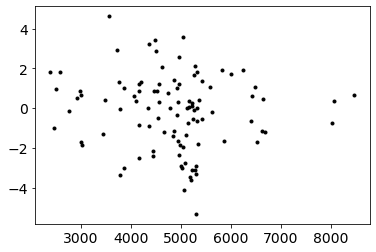

In [78]:
mean_spec_weight = micro_weights[:,:X0.shape[1]]
plt.plot(np.mean(mean_spec_weight, axis=1), rv, 'k.');

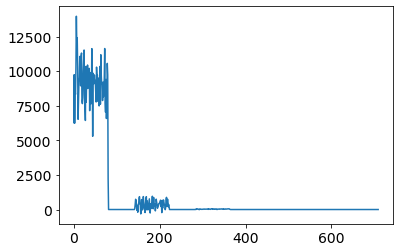

In [75]:
plt.plot(micro_weights[0])

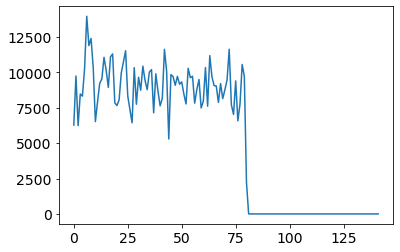

In [76]:
plt.plot(mean_spec_weight[0])

In [26]:
np.shape(micro_weights)

(100, 710)

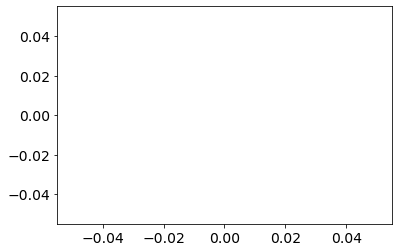

In [27]:
plt.plot(mean_spec_weight[0]);

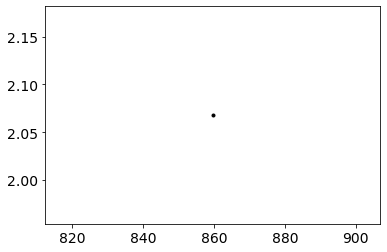

In [28]:
plt.plot(np.std(mean_spec_weight, axis=1), rv, 'k.');

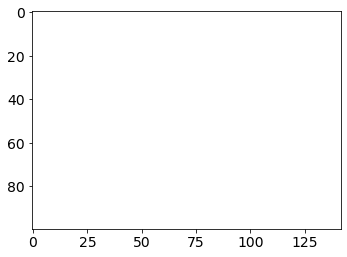

In [29]:
plt.imshow(mean_spec_weight)

In [30]:
weighted_midpoint = np.zeros(n_frames)
for f in range(n_frames):
    weighted_midpoint[f] = np.average(np.arange(mean_spec_weight.shape[1]),weights=mean_spec_weight[f])

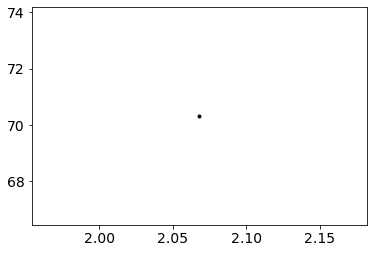

In [31]:
plt.plot(rv, weighted_midpoint, 'k.')

/Users/mbedell/opt/miniconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/mbedell/opt/miniconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

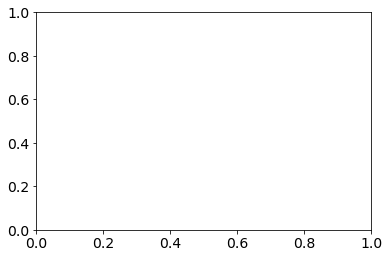

In [32]:
for f in np.arange(5):
    plt.hist(mean_spec_weight[f,:], alpha=0.5);

In [ ]:
plt.imshow(micro_resid[0])
plt.colorbar();

In [ ]:
plt.imshow(X.dot(w).reshape(micro_flux.shape[1:]))